## Importing libraries

In [3]:
!pip install hazm

  Obtaining dependency information for hazm from https://files.pythonhosted.org/packages/e9/16/66fa99ead559a36d56d3a8a9f8b77f1fb03cf6d91d338559325cfe67860d/hazm-0.9.3-py3-none-any.whl.metadata
  Using cached hazm-0.9.3-py3-none-any.whl.metadata (7.9 kB)
  Using cached fasttext_wheel-0.9.2-cp311-cp311-win_amd64.whl (232 kB)
  Using cached python-crfsuite-0.9.9.tar.gz (440 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for pybind11>=2.2 from https://files.pythonhosted.org/packages/06/55/9f73c32dda93fa4f539fafa268f9504e83c489f460c380371d94296126cd/pybind11-2.11.1-py3-none-any.whl.metadata
  Using cached pybind11-2.11.1-py3-none-any.whl.metadata (9.5 kB)
Using cached hazm-0.9.3-py3-none-any.whl (367 kB)
Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Running setup.py clean for python-crfsuite
Failed to build python-crfsuite


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [12 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\pycrfsuite
      copying pycrfsuite\_dumpparser.py -> build\lib.win-amd64-cpython-311\pycrfsuite
      copying pycrfsuite\_logparser.py -> build\lib.win-amd64-cpython-311\pycrfsuite
      copying pycrfsuite\__init__.py -> build\lib.win-amd64-cpython-311\pycrfsuite
      running build_ext
      building 'pycrfsuite._pycrfsuite' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for python-crfsuite
ERROR: C

In [ ]:
!pip install emoji
!pip install transformers

In [ ]:
!pip install imbalanced-learn

In [4]:
import pandas as pd
import re
# from hazm import Normalizer, word_tokenize
import emoji
from transformers import AutoTokenizer, TFBertModel
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, LayerNormalization
# from keras import activations
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from keras import regularizers
from keras.losses import CategoricalCrossentropy

c:\Users\ivarr\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('dataset/2.train_data_text.csv')

## Preprocessing

### Demojizing emojis

In [6]:
df['data'] = df['data'].replace(r'💨', r' ', regex=True)
df['data'] = df['data'].replace(r'😌', r' ', regex=True)
df['data'] = df['data'].replace(r'▪️', r' ', regex=True)

In [7]:
df['data_demojized'] = df['data'].apply(lambda x: emoji.demojize(x))

### Cleaning texts

In [8]:
"""

MAKE SURE TO RETRAIN THE MODEL AGAIN
WITHOUT DELETING HASHTAGS' CONTENT
SOME OF THEM ARE MEANINGFUL
SPECIALLY THOSE IN THE TEXT

"""

rules = [
    r':\s+:',
    r':#', # removing certain # from sentence carring zero-width space
    r'#', # removing hashtag for texts like #مشاهیر_ایران and #مشاهیر_ایران_و_جهان changed #\w+ to #
    r'\(\w{1}\)', # removing (ع) and (ص)
    r'\.$', # removing period at the end of the line
    r'ره', # removing ره from امام ره
    r'\[...\]', # removing three [periods] like [...] مثل آقای
    # r'#\w+\u200c\w+', # removing hashtag coming with zero width non-joiner character like #تل‌آویو
    r'\.{2,}', # removing extra periods like .. and ...
    r'[\،\؛\,\!\«\»\(\)\'\"\“\”\_]', # removing Persian punctuations
    r'\:\w+(_\w+)*\:', # removing demojized emojis in formats like :red_circle
    r'\\U[0-9a-zA-Z]{4,8}', # removing demojized emojis in unicode \Uxxxxxxxx formats NOT FOUND
    r'\w\:', # removing colons
    r'[a-zA-z]{3,}', # removing emoji-remained characters
    r'(?<=تأیید|تایید)',
    r'(?=در)',
    r'(?<=\w)\.(?=\s+)', # removing period from the middle of the line at the end-of-sentence
    r'؟',
    r'(?<=%)'
    ]
df['data_clean'] = df['data_demojized'].replace(rules, r' ', regex=True)

extra_rules = [
    r'(?=ها|های)'
    ]
df['data_clean'] = df['data_clean'].replace(extra_rules, '\u200c', regex=True)

### Normalization

In [ ]:
normalizer = Normalizer()
df['data_normalized'] = df['data_clean'].apply(lambda x: normalizer.normalize(x))

##### Testing text cleaning and normalization

In [ ]:
no = 2836
print(df['data'][no])
print(df['data_clean'][no])
print(df['data_normalized'][no])

In [ ]:
text = 'لاریجانی رئیس مجمع تشخی از حضور این‌جانب در شورای نگهبان در سال ۱۳۸۰ هیچ‌گاه تصمیمات شورا را تا این حد غیرقابل دفاع نیافته‌ام چه در تأیید صلاحیت‌ها و چه در عدم‌احراز صلاحیت‌ها. با نظارت استصوابی و شورای نگهبان یک‌دست اصولگرا آش همان آش و کاسه همان کاسه است'
for rule in rules:
    print(re.sub(rule, r' ', text))

In [ ]:
'''

 Testing data

'''
print(df[df['data_normalized'].str.contains(r'\.(?=\s\w)', regex=True)][['data_normalized']])

In [ ]:
import re

text = "سرمایههای وطنی"

# Add a space before "ها" or "های"
modified_text = re.sub(r'(?=ها|های)', '\u200c', text)

print(modified_text)

سرمایه‌های وطنی


### Tokenization

In [ ]:
df['data_tokenized'] = df['data_normalized'].apply(lambda x: word_tokenize(x))

### Removing stopwords

In [ ]:
stopwords = [
    "از", "به", "که", "در", "با", "این", "برای", "را", "هم", "تا", "آن", "یا", "است", "یک", "نیز", "اما",
    "هر", "بود", "باشد", "ما", "شما", "او", "آنها", "تو", "من", "اگر", "بی", "اون", "رو", "بودم", "نه", "باشه",
    "شده", "اونا", "هست", "هستم", "خود", "خودش", "خودم", "ای", "منم", "توی", "چه", "چرا", "کی", "چی", "همین",
    "حتی", "الان", "حالا", "تونسته", "همه", "همون", "کل", "قبل", "هرکسی", "هرچیزی", "همچنین", "همچون", "آیا",
    "اکنون", "باید", "بعد", "پس", "پیش", "توسط", "تمام", "تر", "ترین", "جز", "حتما", "خیلی", "دیگر", "راه",
    "زیاد", "سعی", "شد", "شماها", "کاملا", "کامل", "مثل", "مثلا", "می", "همچین", "واقعا", "ولی", "یکی", "یعنی",
    "یه", "یکم", "چون", "بعضی", "هموطن", "وی", "شو", "دو", "کرد", "کردم", "کرده", "کردن", "کردند", "کردی",
    "کردید", "کرده‌اند", "کردم‌", "کنم", "کنی", "کنند", "کنید", "کند", "کنیم", "کندم", "کنیم", "کنونی", "کنونی‌",
    "کردم ", "کردم‌ ", "کردیم‌ ", "کرده‌ ", "کرده‌اند ", "کرده‌ام ", "کرده‌ای ", "کرده‌ایم ", "کرده‌اند‌ ",
    "کنم‌ ", "کنیم‌ ", "کنیم‌‌ ", "کنید‌ ", "کنید‌‌ ", "کنند‌ ", "کرد‌ ", "کرد‌‌ ", "کردم‌‌ ", "کرده‌‌ ",
    "کرده‌‌‌‌ ", "کرده‌ام‌‌ ", "کرده‌ای‌‌‌ ", "کرده‌ایم‌ ", "کرده‌اند‌‌ ", "کنم‌‌ ", "کنی‌‌ ", "کنند‌‌ ",
    "کنید‌‌ ", "کنید‌‌‌‌ ", "کنیم‌‌‌‌ ", "کنونی‌‌ ", "کنو"
]
# stopwords_count = Counter([word for sublist in df.iloc[:, 2] for word in sublist if word in stopwords])
# stopwords_list = sorted(stopwords_count.items(), key=lambda x: x[1], reverse=True)

# for word, count in stopwords_list:
#     print(f"{word}: {count}")

def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in stopwords]
    return filtered_tokens

df['data_stopwords_removed'] = df['data_tokenized'].apply(remove_stopwords)

### Lemmatization

In [ ]:
# lemmatizer = Lemmatizer()
# df['data_lemmatized'] = df['data_stopwords_removed'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [ ]:
# df['num_lemmatized_words'] = df.apply(lambda row: sum(1 for i, token in enumerate(row['data_stopwords_removed']) if token != row['data_lemmatized'][i]), axis=1)

In [ ]:
df['data_preprocessed'] = df['data_tokenized'].apply(lambda tokens: ''.join(tokens))

# df['data_preprocessed'] = df['data_stopwords_removed'].apply(lambda tokens: ' '.join(tokens))

## Word embedding

### Padding?

In [ ]:
'''

TO RUN THIS CELL
RUN THE CELL BELOW
BEFORE RUNNING THIS
AS MAX_LENGTH COMES
THROUGH THE CELL BELOW

'''
need_padding = df['data_normalized'].apply(lambda tokens: len(tokens) < max_length)
print(need_padding)

0       False
1       False
2       False
3       False
4       False
        ...  
3864    False
3865    False
3866    False
3867    False
3868    False
Name: data_normalized, Length: 3869, dtype: bool


### Finding the max_length

In [ ]:
def max_len(dataset):
    return max(dataset['data_tokenized'].apply(lambda x: len(x)))

max_length = max_len(df)
max_length

68

In [ ]:
print('Longest max_length as index of data_normalized column:', df['data_tokenized'].str.len().idxmax())

Longest max_length as index of data_normalized column: 64


### PARSBERT model

In [9]:
tokenizer = AutoTokenizer.from_pretrained('HooshvareLab/bert-base-parsbert-uncased')

In [10]:
bert_model = TFBertModel.from_pretrained('HooshvareLab/bert-base-parsbert-uncased')

Some layers from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [12]:
max_length = 68
batch_size = 32
num_samples = len(df)
num_batches = int(np.ceil(num_samples / batch_size))

embeddings_list = []

for i in range(num_batches):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, num_samples)
    batch = df['data_clean'][start_index:end_index]

    tokenized_tensors = tokenizer.batch_encode_plus(
        batch.tolist(),
        add_special_tokens=True,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='tf'
    )['input_ids']

    outputs = bert_model(tokenized_tensors)
    embeddings = outputs.last_hidden_state.numpy()
    embeddings_list.append(embeddings)

embeddings = np.concatenate(embeddings_list, axis=0)

print(f"Final embeddings shape: {embeddings.shape}")

Final embeddings shape: (3869, 68, 768)


In [ ]:
total_sentences = (241 * batch_size) + 13
total_sentences

3869

In [31]:
np.save('parsbert_embeddings_input_ids.npy', embeddings)

## Word2Vec model

In [ ]:
model = Word2Vec(df['data_tokenized'],
                 vector_size=max_length,
                 alpha=0.001,
                 window=10,
                 min_count=1,
                 workers=4,
                 sg=1,
                 hs=0,
                 negative=20
                 )

In [ ]:
y = df.iloc[:, 3:14]

In [ ]:
target_vectors = df.iloc[:, 3:14].applymap(lambda x: model.wv[x]).values.tolist()
target_vectors_df = pd.DataFrame(target_vectors)

In [ ]:
target_vectors_df

,0,1,2,3,4,5,6,7,8,9,10
0,"[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733..."
1,"[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733..."
2,"[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ..."
3,"[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733..."
4,"[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ..."
...,...,...,...,...,...,...,...,...,...,...,...
3864,"[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733..."
3865,"[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35235533, 0.8212422, 0.1741617, 0.5656758, ...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.35608754, 0.82468987, 0.17659916, 0.5669733...","[0.3560

In [ ]:
def vector_to_text(vector):
    similar_words = model.wv.similar_by_vector(vector, topn=1)
    return similar_words[0][0]

# Convert the numeric values back to text
text_vectors = target_vectors_df.applymap(vector_to_text)

# Display the DataFrame with text vectors
print(text_vectors)

      0   1   2   3   4   5   6  7   8  9   10
0      و  در  در   و  در   و  در  و   و  و   و
1      و   و   و   و  در   و  در  و   و  و   و
2      و   و   و  در   و   و  در  و  در  و  در
3      و   و  در   و   و   و  در  و  در  و   و
4      و   و  در   و   و   و  در  و  در  و  در
...   ..  ..  ..  ..  ..  ..  .. ..  .. ..  ..
3864   و   و  در   و   و  در  در  و   و  و   و
3865   و   و  در   و   و   و  در  و   و  و   و
3866   و   و  در   و   و   و  در  و  در  و  در
3867   و  در   و   و   و   و   و  و   و  و   و
3868  در   و   و   و   و   و   و  و   و  و   و

[3869 rows x 11 columns]


In [ ]:
model.train(df['data_tokenized'],
               total_examples=len(df['data_tokenized']),
               epochs=10)

(1343379, 1601060)

[('وجود', 0.9993520379066467),
 ('برابر', 0.9993158578872681),
 ('نمی\u200cشود', 0.9993118047714233),
 ('تولید', 0.9993026852607727),
 ('حفظ', 0.99929279088974)]

In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# words = model.wv.index_to_key
# word_vectors = model.wv[words]

# tsne = TSNE(n_components=2, random_state=42)
# word_vectors_tsne = tsne.fit_transform(word_vectors)

# plt.figure(figsize=(10, 10))
# for i, word in enumerate(words):
#     x, y = word_vectors_tsne[i, :]
#     plt.scatter(x, y)
#     plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
# plt.show()

In [ ]:
model.save('persian_word2vec.model')

In [ ]:
word2vec_model = Word2Vec.load('persian_word2vec.model')

In [ ]:
# word_vectors = word2vec_model.wv
word_vectors = model.wv

In [ ]:
max_sequence_length = len(df['data_tokenized'][df['data_tokenized'].str.len().idxmax()])

embedding_layer = Embedding(input_dim=len(word_vectors.key_to_index),
                            output_dim=word_vectors.vector_size,
                            weights=[word_vectors.vectors],
                            input_length=max_sequence_length,
                            trainable=False
                            )

## Extreme learning machine

In [72]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge

# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(embeddings, df.iloc[:, 3:14], test_size=0.2, random_state=42)


# Define the number of hidden neurons
n_hidden = 100

# Generate random input weights and biases
input_weights = np.random.uniform(-1, 1, (X_train.shape[1], n_hidden))
biases = np.random.uniform(-1, 1, n_hidden)

# Calculate the hidden layer output
hidden_output = np.dot(X_train, input_weights) + biases
hidden_output = np.maximum(hidden_output, 0)  # Apply ReLU activation function

# Solve the output weights using ridge regression
output_weights = np.dot(np.linalg.pinv(hidden_output), y_train)

# Calculate the testing hidden layer output
hidden_output_test = np.dot(X_test, input_weights) + biases
hidden_output_test = np.maximum(hidden_output_test, 0)  # Apply ReLU activation function

# Predict the testing labels
y_pred = np.dot(hidden_output_test, output_weights)
y_pred = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True) 

# Convert the predictions to class labels
y_pred = np.argmax(y_pred, axis=1)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

ValueError: shapes (3095,68,768) and (68,100) not aligned: 768 (dim 2) != 68 (dim 0)

## LSTM

In [38]:
X = embeddings
y = df.iloc[:, 3:14]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# class_distribution = np.sum(y_train, axis=0) / y_train.shape[0]

# class_weights = 1 / (class_distribution + 1e-6)
# class_weights /= np.sum(class_weights)

# class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# small_details_weight = 2.0

# model.add(LSTM(units=128, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=32))
# model.add(Dropout(0.2))

# model.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# # Use Focal Loss as the loss function
# def focal_loss(gamma=2.0, alpha=0.25):
#     def focal_loss_fn(y_true, y_pred):
#         ce_loss = CategoricalCrossentropy()(y_true, y_pred)
#         pt = K.exp(-ce_loss)
#         focal_loss = alpha * K.pow(1 - pt, gamma) * ce_loss
#         return focal_loss
#     return focal_loss_fn

# model.compile(loss=focal_loss(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=100, batch_size=32)

# loss, accuracy = model.evaluate(X_test, y_test)
# print('Test loss:', loss)
# print('Test accuracy:', accuracy)

In [70]:
model = Sequential()

model.add(LSTM(
              units=32,
              activation='tanh',
              recurrent_activation='hard_sigmoid',
              return_sequences=True
              ))
model.add(LayerNormalization(
                            axis=-1,
                            epsilon=0.001,
                            center=True,
                            scale=True,
                            beta_initializer='zeros',
                            gamma_initializer='ones',
                            beta_regularizer=None,
                            gamma_regularizer=None,
                            beta_constraint=None,
                            gamma_constraint=None
                            ))
# model.add(Dropout(0.1))
# model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=24))

model.add(Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) #sample_weight_mode=class_weights_dict

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

In [27]:
y_pred = model.predict(X_test)

threshold = 0.5
y_test_threshold = (y_test > threshold).astype(int)
y_pred_threshold = (y_pred > threshold).astype(int)

precision, recall, f_score, _ = precision_recall_fscore_support(y_test_threshold, y_pred_threshold, average='micro')

print('Precision:', precision)
print('Recall:', recall)
print('F-score:', f_score)

25/25 [==============================] - 9s 356ms/step
Precision: 0.4691358024691358
Recall: 0.023543990086741014
F-score: 0.04483775811209439


In [26]:
report = classification_report(y_test_threshold, y_pred_threshold, zero_division=1)
print(report)
# with open('classification_report.txt', "w") as file:
#     file.write(report)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       189
           1       1.00      0.00      0.00       111
           2       1.00      0.00      0.00       397
           3       0.00      0.00      1.00        65
           4       0.00      0.00      1.00        50
           5       0.00      0.00      1.00        84
           6       0.57      0.58      0.58       391
           7       0.00      0.00      1.00        26
           8       0.12      0.04      0.05       141
           9       1.00      0.00      0.00        25
          10       1.00      0.00      0.00       135

   micro avg       0.51      0.14      0.22      1614
   macro avg       0.52      0.06      0.42      1614
weighted avg       0.68      0.14      0.28      1614
 samples avg       0.72      0.12      0.45      1614



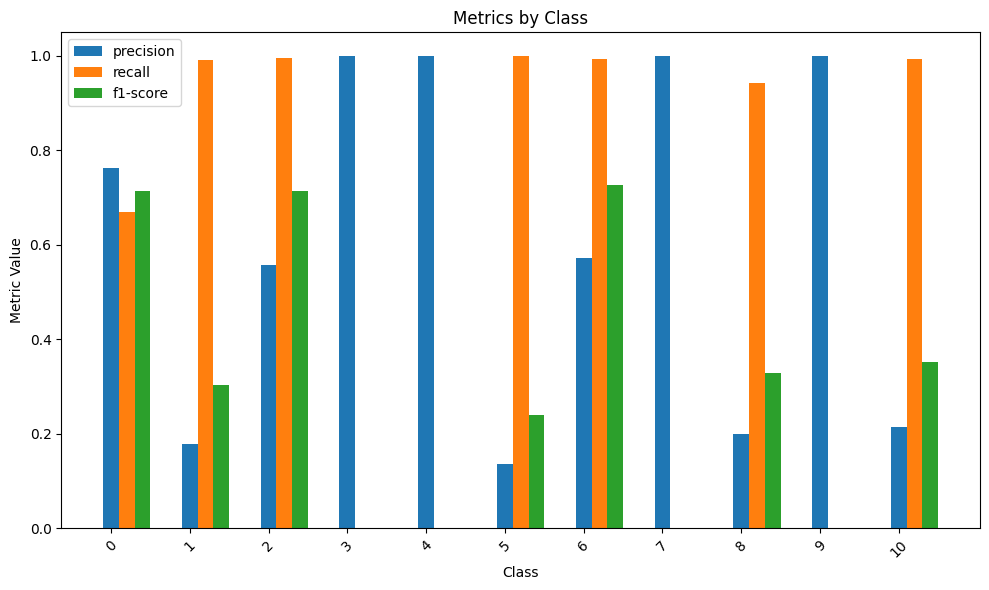

In [ ]:
class_labels = list(report.keys())[:-4]
metrics = ['precision', 'recall', 'f1-score']

metric_values = {metric: [] for metric in metrics}

for label in class_labels:
    for metric in metrics:
        metric_values[metric].append(report[label][metric])

x = np.arange(len(class_labels))
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + (i * width), metric_values[metric], width, align='center', label=metric)

ax.set_xlabel('Class')
ax.set_ylabel('Metric Value')
ax.set_title('Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 68, 128)           459264    
                                                                 
 lstm_1 (LSTM)               (None, 68, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 11)                363       
                                                                 
Total params: 521,451
Trainable params: 521,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save('keras_lstm_model.h5')

In [74]:
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_model(optimizer='adam', activation='sigmoid', dropout_rate=0.0, lstm_units=32):
    model = Sequential()
    model.add(LSTM(
                units=lstm_units,
                activation=activation,
                recurrent_activation='hard_sigmoid',
                return_sequences=True
                ))
    model.add(Dropout(rate=dropout_rate))
    model.add(LSTM(units=lstm_units))
    model.add(Dense(11, activation=activation))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KerasClassifier(build_fn=create_model, verbose=1))
])

param_grid = {
    'model__optimizer': ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'],
    'model__activation': ['relu', 'sigmoid', 'softmax', 'tanh', 'linear', 'elu', 'selu', 'softplus', 'hard_sigmoid'],
    'model__dropout_rate': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'model__lstm_units': [16, 32, 64, 128],
    'model__batch_size': [16, 32, 64]
}

# Perform grid search with cross-validation
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train, callbacks=[EarlyStopping(patience=5)])

# Print the best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

ModuleNotFoundError: No module named 'keras.wrappers'